# Relation Extraction with a BERT Model over RareDis Dataset

In this project, there are developed the necessary steps to deploy a Bidirectional Encoder Representations from Transformers (BERT) model to extract and classify relations between words from the RareDis dataset.

## 1. Connection with the cloud files

First of all, it is necessary to activate Google Drive in the execution environment (it is also possible to execute `drive.flush_and_unmount()` to unmount the current session, if it is established previously).

In [ ]:
#drive.flush_and_unmount() # Optional, only if necessary
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The next step is optional, it is only for checking purpose to test the correct connection with Google Drive and see the current files. It also serves to define a path to work on.

In [ ]:
root = '/content/drive/My Drive/Colab Notebooks'
#!ls '/content/drive/My Drive/Colab Notebooks'
print("Current directory: {}".format(root))

Current directory: /content/drive/My Drive/Colab Notebooks


For execution purposes, it is recommendable to ensure that TensorFlow uses GPU. 
In the following some layers will choose different implementations (cuDNN-based or pure-TensorFlow) to maximize the performance. If a GPU is available and all the arguments to the layer meet the requirement of the CuDNN kernel (see each layer separately), the layer will use a fast cuDNN implementation.
Currently, GRU layer supports CuDNN.

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

# If not working try
#!pip install tensorflow==2.1.0

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15047843036861464510
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15565350041002277003
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Default GPU Device: /device:GPU:0


If TensorBoard is to be used, this cell is required. It includes the use of the `tensorboard.notebook` APIs for a bit more control if desired.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

from tensorboard import notebook
notebook.list() # View open TensorBoard instances

# Control TensorBoard display. If no port is provided, the most recently launched TensorBoard is used
#notebook.display(port=6006, height=1000)

No known TensorBoard instances running.


## 2. Reading and preprocessing of the dataset

Here, the execution of the actual code is started. At first, all the necessary libraries to deploy the structure are imported for Python.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import optimizers, losses, metrics
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
import spacy #NLP library for sentence segmentation and tokenization
nlp = spacy.load("en_core_web_sm")
pd.set_option('max_colwidth', None)

After this, the RareDis dataset is readed into a Pandas DataFrame using some data manipulation techniques. For this task, it is necessary to keep the "Sentences" and "Labels" as columns of the resulting dataset.



In [ ]:
# Definition of Train & Test Paths
path_train = root + '/relation_extraction/data/gold_nlp4rare_corpus/train.csv'
path_dev = root + '/relation_extraction/data/gold_nlp4rare_corpus/dev.csv'
path_test = root + '/relation_extraction/data/gold_nlp4rare_corpus/test.csv'

# Read of all the datasets
RareDis_df_train = pd.read_csv(path_train)
RareDis_df_train.drop(columns=['Unnamed: 0'], inplace=True)

RareDis_df_dev = pd.read_csv(path_dev)
RareDis_df_dev.drop(columns=['Unnamed: 0'], inplace=True)

RareDis_df_test = pd.read_csv(path_test)
RareDis_df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
RareDis_df_dev

,Sentence,Relation,e1,e2
0,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_a,Cat eye syndrome,chromosomal disorder
1,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_acron,CES,Cat eye syndrome
2,Additional chromosomal disorders may have features similar to those associated with Chromosome 14 Ring.,Is_a,chromosomal disorders,chromosomal disorder
3,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",Produces,Chromosome 9 Ring,growth retardation
4,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",Produces,Chromosome 9 Ring,heart defects
...,...,...,...,...
254,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,kidney disease
255,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,proteinuria
256,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,hematuria
257,"Patients may present with symptoms associated with low blood calcium (hypocalcemia) such as muscle weakness, tetany, and convulsions, or findings related to kidney disease such as proteinuria, hematuria, and nephrotic syndrome.",Produces,nephrotic syndrome,nephrotic syndrome


It is possible to check a distribution of the actual lengths for the sentences of the dataset to infer the desired value of MAX_LENGTH.

Maximum sentence length for train data is 86
Maximum sentence length for dev data is 71
Maximum sentence length for test data is 84


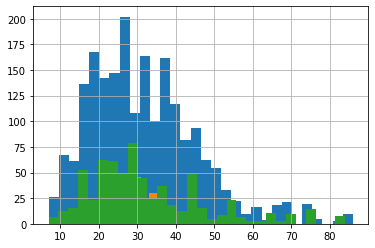

In [ ]:
# Train dataset
seq_len_train = [len(nlp(sentence)) for sentence in RareDis_df_train["Sentence"]]
pd.Series(seq_len_train).hist(bins = 30)
print('Maximum sentence length for train data is {}'.format(max(seq_len_train)))

# Dev dataset
seq_len_dev = [len(nlp(sentence)) for sentence in RareDis_df_dev["Sentence"]]
pd.Series(seq_len_dev).hist(bins = 30)
print('Maximum sentence length for dev data is {}'.format(max(seq_len_dev)))

# Test dataset
seq_len_test = [len(nlp(sentence)) for sentence in RareDis_df_test["Sentence"]]
pd.Series(seq_len_test).hist(bins = 30)
print('Maximum sentence length for test data is {}'.format(max(seq_len_test)))

In [ ]:
# Define maximum desired length for the sentences
MAX_LENGTH = 90

For this model it will be taken into account both the relatives position of the 2 entities that appears in each of the sentences of the dataset. The relative positions will be stored as new columns in the DataFrame. The following cell serves as an example of the necessary prosecution to perform this operation.

In [ ]:
selected = 4

print(RareDis_df_dev.iloc[selected]["Sentence"])

span_sentence = nlp(RareDis_df_dev.iloc[selected]["Sentence"])
span_e1 = nlp(RareDis_df_dev.iloc[selected]["e1"])
span_e2 = nlp(RareDis_df_dev.iloc[selected]["e2"])
print('Sentence lenght (in tokens): ', len(span_sentence))
print('e1: ', RareDis_df_dev.iloc[selected]["e1"], '|| e1 lenght (in tokens): ', len(span_e1))
print('e2: ', RareDis_df_dev.iloc[selected]["e2"], '|| e2 lenght (in tokens): ', len(span_e2))

e1_position = np.zeros(MAX_LENGTH)
e2_position = np.zeros(MAX_LENGTH)

e1_min_pos = len(span_sentence)
e1_max_pos = 0
e2_min_pos = len(span_sentence)
e2_max_pos = 0

for token_e1 in span_e1:
    for token_s in span_sentence:
        # print((token_s.text, token_s.i))
        if token_e1.text == token_s.text:
            e1_min_pos = min(e1_min_pos, token_s.i)
            e1_max_pos = max(e1_max_pos, token_s.i)
            break

for token_e2 in span_e2:
    for token_s in span_sentence:
        # print((token_s.text, token_s.i))
        if token_e2.text == token_s.text:
            e2_min_pos = min(e2_min_pos, token_s.i)
            e2_max_pos = max(e2_max_pos, token_s.i)
            break

print('e1 min pos in sentence: ', e1_min_pos)
print('e1 max pos in sentence: ', e1_max_pos)
print('e2 min pos in sentence: ', e2_min_pos)
print('e2 max pos in sentence: ', e2_max_pos)

e2_position[:e2_min_pos] = [(i-e2_min_pos)*(-1)  for i in range(e2_min_pos)]
e2_position[e2_max_pos:] = [i  for i in range(len(e2_position)-e2_max_pos)]
e1_position[:e1_min_pos] = [(i-e1_min_pos)*(-1)  for i in range(e1_min_pos)]
e1_position[e1_max_pos:] = [i  for i in range(len(e1_position)-e1_max_pos)]
print('vector for e1: ', e1_position)
print('vector for e2: ', e2_position)

Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.
Sentence lenght (in tokens):  29
e1:  Chromosome 9 Ring || e1 lenght (in tokens):  3
e2:  heart defects || e2 lenght (in tokens):  2
e1 min pos in sentence:  0
e1 max pos in sentence:  2
e2 min pos in sentence:  19
e2 max pos in sentence:  20
vector for e1:  [ 0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.
 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.
 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69.
 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87.]
vector for e2:  [19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.
  1.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.
 16. 17. 18. 19. 20. 21. 22. 23

Now we define the function to apply to each row of the dataset and perform the operation to all the datasets.

In [ ]:
def getRelativePosition(row):
    span_sentence = nlp(row["Sentence"])
    span_e1 = nlp(row["e1"])
    span_e2 = nlp(row["e2"])
    e1_min_pos = len(span_sentence)
    e1_max_pos = 0
    e2_min_pos = len(span_sentence)
    e2_max_pos = 0
    for token_e1 in span_e1:
        for token_s in span_sentence:
            if token_e1.text == token_s.text:
                e1_min_pos = min(e1_min_pos, token_s.i)
                e1_max_pos = max(e1_max_pos, token_s.i)
                break
    for token_e2 in span_e2:
        for token_s in span_sentence:
            if token_e2.text == token_s.text:
                e2_min_pos = min(e2_min_pos, token_s.i)
                e2_max_pos = max(e2_max_pos, token_s.i)
                break
    e1_position = np.zeros(MAX_LENGTH)
    e2_position = np.zeros(MAX_LENGTH)
    e2_position[:e2_min_pos] = [(i-e2_min_pos)*(-1)  for i in range(e2_min_pos)]
    e2_position[e2_max_pos:] = [i  for i in range(len(e2_position)-e2_max_pos)]
    e1_position[:e1_min_pos] = [(i-e1_min_pos)*(-1)  for i in range(e1_min_pos)]
    e1_position[e1_max_pos:] = [i  for i in range(len(e1_position)-e1_max_pos)]
    
    return e1_position, e2_position


test_1, test_2 = getRelativePosition(RareDis_df_dev.iloc[selected])
assert np.array_equal(test_1, e1_position) 
assert np.array_equal(test_2, e2_position)
print("Function ok")

Function ok


In [ ]:
RareDis_df_train[['e1_pos', 'e2_pos']] = RareDis_df_train.apply(getRelativePosition, axis=1, result_type="expand")
RareDis_df_dev[['e1_pos', 'e2_pos']] = RareDis_df_dev.apply(getRelativePosition, axis=1, result_type="expand")
RareDis_df_test[['e1_pos', 'e2_pos']] = RareDis_df_test.apply(getRelativePosition, axis=1, result_type="expand")

In [ ]:
RareDis_df_dev

,Sentence,Relation,e1,e2,e1_pos,e2_pos
0,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_a,Cat eye syndrome,chromosomal disorder,"[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]","[9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0]"
1,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,Is_acron,CES,Cat eye syndrome,"[4.0, 3.0, 2.0, 1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0]","[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]"
2,Additional chromosomal disorders may have features similar to those associated with Chromosome 14 Ring.,Is_a,chromosomal disorders,chromosomal disorder,"[1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]","[1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0]"
3,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",Produces,Chromosome 9 Ring,growth retardation,"[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 2

Mapping the labels per integers is the first step to apply one hot encoding afterwards. For this step, we group the categories into the different possible relations.

In [ ]:
labels_dict = {'Produces': 0,
               'Increases_risk_of': 1,
               'Is_a': 2,
               'Is_acron': 3,
               'Is_synon': 4,
               }
RareDis_df_train["Relation"] = RareDis_df_train["Relation"].map(labels_dict)
RareDis_df_dev["Relation"] = RareDis_df_dev["Relation"].map(labels_dict)
RareDis_df_test["Relation"] = RareDis_df_test["Relation"].map(labels_dict)

In [ ]:
RareDis_df_dev

,Sentence,Relation,e1,e2,e1_pos,e2_pos
0,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,2,Cat eye syndrome,chromosomal disorder,"[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]","[9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0]"
1,Cat eye syndrome (CES) is a rare chromosomal disorder that may be evident at birth.,3,CES,Cat eye syndrome,"[4.0, 3.0, 2.0, 1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0]","[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]"
2,Additional chromosomal disorders may have features similar to those associated with Chromosome 14 Ring.,2,chromosomal disorders,chromosomal disorder,"[1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0]","[1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0]"
3,"Chromosome 9 Ring may also be characterized by additional physical features in some cases, including growth retardation, heart defects, genital abnormalities, and/or other findings.",0,Chromosome 9 Ring,growth retardation,"[0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.

In the same way that the sentences are tokenized in the resulting matrix `X_train` for training data, it will be necessary to adapt the matrix for each of the relative positions correctly to feed the neural network afterwards. These matrices will be called (`X_train_pos1`,`X_train_pos2`), (`X_dev_pos1`,`X_dev_pos2`) and (`X_test_pos1`,`X_test_pos2`).

In [ ]:
# Processing for train data
X_train_pos1 = [value for value in RareDis_df_train["e1_pos"].values]
X_train_pos1 = np.array(X_train_pos1, dtype='float32')
X_train_pos2 = [value for value in RareDis_df_train["e2_pos"].values]
X_train_pos2 = np.array(X_train_pos2, dtype='float32')

# Processing for dev data
X_dev_pos1 = [value for value in RareDis_df_dev["e1_pos"].values]
X_dev_pos1 = np.array(X_dev_pos1, dtype='float32')
X_dev_pos2 = [value for value in RareDis_df_dev["e2_pos"].values]
X_dev_pos2 = np.array(X_dev_pos2, dtype='float32')

# Processing for test data
X_test_pos1 = [value for value in RareDis_df_test["e1_pos"].values]
X_test_pos1 = np.array(X_test_pos1, dtype='float32')
X_test_pos2 = [value for value in RareDis_df_test["e2_pos"].values]
X_test_pos2 = np.array(X_test_pos2, dtype='float32')

# Outputs
print('X_train_pos1 shape is {}'.format(X_train_pos1.shape))
print('X_train_pos2 shape is {}'.format(X_train_pos2.shape))
print('X_dev_pos1 shape is {}'.format(X_dev_pos1.shape))
print('X_dev_pos2 shape is {}'.format(X_dev_pos2.shape))
print('X_test_pos1 shape is {}'.format(X_test_pos1.shape))
print('X_test_pos2 shape is {}'.format(X_test_pos2.shape))

X_train_pos1 shape is (2052, 90)
X_train_pos2 shape is (2052, 90)
X_dev_pos1 shape is (259, 90)
X_dev_pos2 shape is (259, 90)
X_test_pos1 shape is (657, 90)
X_test_pos2 shape is (657, 90)


## 3. Building the BERT Model

The BERT (Bidirectional Encoder Representations from Transformers) model is a bidirectional transformer pre-trained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.
The unsupervised tasks like next sentence prediction on which BERT is trained allows us to use a pre-trained BERT model by fine-tuning the same on downstream specific tasks.
The models are based in Google Research pre-trained models, available [here](https://github.com/google-research/bert).

- For this task, which can be catalogued as a classification task, it is used a `TFBertForSequenceClassification` model with a `bert-base-uncased` pre-trained model. This model uses a concatenation of `TFBertMainLayer` plus a `Dropout` layer plus a `Dense` layer. Source code: [here](https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_tf_bert.html#TFBertForSequenceClassification).
- A complete list of all models can be found [here](https://huggingface.co/transformers/model_doc/bert.html).
- A complete list of all pre-trained models can be found [here](https://huggingface.co/transformers/pretrained_models.html).

The processes of tokenization involve splitting the input text into a list of tokens that are available in the vocabulary. In order to deal with the words not available in the vocabulary, BERT uses a technique called BPE based WordPiece tokenization. In this approach, an out of vocabulary word is progressively split into subwords and the word is then represented by a group of subwords. Since the subwords are part of the vocabulary, we have learned representations a context for these subwords and the context of the word is simply the combination of the context of the subwords.

In [ ]:
# Required configuration and imports
!pip install transformers
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import AdamWeightDecay # Optional optimizer if desired

Initially, the encode of the data is performed.

In [ ]:
# Encoding of the data
sentences_train = RareDis_df_train["Sentence"]
sentences_dev = RareDis_df_dev["Sentence"]
sentences_test = RareDis_df_test["Sentence"]

labels_train = RareDis_df_train["Relation"]
labels_dev = RareDis_df_dev["Relation"]
labels_test = RareDis_df_test["Relation"]

print('[TRAIN] Sentences length: {}. Labels length: {}.'.format(len(sentences_train), len(labels_train)))
print('[DEV] Sentences length: {}. Labels length: {}.'.format(len(sentences_dev), len(labels_dev)))
print('[TEST] Sentences length: {}. Labels length: {}.'.format(len(sentences_test), len(labels_test)))

[TRAIN] Sentences length: 2052. Labels length: 2052.
[DEV] Sentences length: 259. Labels length: 259.
[TEST] Sentences length: 657. Labels length: 657.


Next the encoding of the text data using the BERT Tokenizer is computed and both the `input_ids` and `attentions_masks` are calculated to feed them into the model.

In [ ]:
# Charging BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# Loading the sentences into the BERT Tokenizer
train_inp = []
train_mask = []
for sentence in sentences_train:
    bert_inp = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, return_attention_mask=True)
    train_inp.append(bert_inp['input_ids'])
    train_mask.append(bert_inp['attention_mask'])

val_inp = []
val_mask = []
for sentence in sentences_dev:
    bert_inp = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, return_attention_mask=True)
    val_inp.append(bert_inp['input_ids'])
    val_mask.append(bert_inp['attention_mask'])

test_inp = []
test_mask = []
for sentence in sentences_test:
    bert_inp = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, return_attention_mask=True)
    test_inp.append(bert_inp['input_ids'])
    test_mask.append(bert_inp['attention_mask'])


train_inp = np.asarray(train_inp)
train_mask = np.array(train_mask)
train_label = np.array(labels_train)

val_inp = np.asarray(val_inp)
val_mask = np.asarray(val_mask)
val_label = np.array(labels_dev)

test_inp = np.asarray(test_inp)
test_mask = np.asarray(test_mask)
test_label = np.array(labels_test)


print('[TRAIN] input_ids length: {}.\nattention_masks length: {}.\nlabels length: {}.'.format(len(train_inp), len(train_mask), len(train_label)))
print('[DEV] input_ids length: {}.\nattention_masks length: {}.\nlabels length: {}.'.format(len(val_inp), len(val_mask), len(val_label)))
print('[TEST] input_ids length: {}.\nattention_masks length: {}.\nlabels length: {}.'.format(len(test_inp), len(test_mask), len(test_label)))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[TRAIN] input_ids length: 2052.
attention_masks length: 2052.
labels length: 2052.
[DEV] input_ids length: 259.
attention_masks length: 259.
labels length: 259.
[TEST] input_ids length: 657.
attention_masks length: 657.
labels length: 657.


An optional module to save the data into pickle files is provided in order to conserve the outputs for the future.

In [ ]:
# Saving the data into the pickle files
saving = False # Set by user

if saving:
  import pickle
  print('Preparing the pickle file.....')
  PICKLE_INP_PATH = root + '/relation_extraction/bert/bert_inp.pkl'
  PICKLE_MASK_PATH = root + '/relation_extraction/bert/bert_mask.pkl'
  PICKLE_LABEL_PATH = root + '/relation_extraction/bert/bert_label.pkl'
  pickle.dump((input_ids), open(PICKLE_INP_PATH, 'wb'))
  pickle.dump((attention_masks), open(PICKLE_MASK_PATH, 'wb'))
  pickle.dump((labels), open(PICKLE_LABEL_PATH, 'wb'))
  print('Pickle files saved as ',PICKLE_INP_PATH,PICKLE_MASK_PATH,PICKLE_LABEL_PATH)
else:
  print('No pickle file saved')

No pickle file saved


Same as before, an optional module to load data from pickle files is provided.

In [ ]:
# Loading the data from the pickle files
loading = False # Set by user

if loading:
  print('Loading the saved pickle files..')
  input_ids = pickle.load(open(PICKLE_INP_PATH, 'rb'))
  attention_masks = pickle.load(open(PICKLE_MASK_PATH, 'rb'))
  labels = pickle.load(open(PICKLE_LABEL_PATH, 'rb'))
else:
  print('No pickle file loaded')

No pickle file loaded


In [ ]:
# Definition of NUM_CLASSES
NUM_CLASSES = len(RareDis_df_train["Relation"].unique())
print('Nr of classes: {}\n'.format(NUM_CLASSES))

Nr of classes: 5



With the preprocessing done, the declaration of the model is the following step.

In [ ]:
# Declaration of the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=NUM_CLASSES)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now the fine-tuning process for the pre-trained BERT model is executed.

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_151 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0
_________________________________________________________________
Bert Model: None


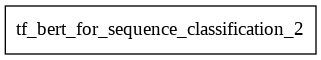

In [ ]:
# Setting up the model hyperparameters
BATCH_SIZE = 64
EPOCHS = 25
LOSS = losses.SparseCategoricalCrossentropy(from_logits=True)
METRIC = metrics.SparseCategoricalAccuracy('accuracy')
OPTIMIZER = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08)
#OPTIMIZER = keras.optimizers.SGD(learning_rate=1e-3)

# Compiling the model
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

# Visualization of the model
print('Bert Model:', model.summary())
plot_model(model, show_shapes=True)

Training the model.

In [ ]:
# Definition of the callbacks
es = True # EarlyStopping use
mc = False # ModelCheckpoint use
tb = False # TensorBoard use

my_callbacks = []
if es:
  my_callbacks.append(EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True))
  print('Used EarlyStopping')
if mc:
  CHECKPOINT_FILEPATH = root+'/relation_extraction/checkpoints/'+'bert.h5'
  my_callbacks.append(ModelCheckpoint(filepath=CHECKPOINT_FILEPATH, monitor='val_loss', mode='min', verbose=1, save_best_only=True))
  print('Used ModelCheckpoint')
if tb:
  import datetime, os
  logdir = os.path.join(root+'/relation_extraction/logs/fit/', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  my_callbacks.append(TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=False))
  %tensorboard --logdir /content/drive/MyDrive/Colab\ Notebooks/relation_extraction/logs # to monitor the training in progress
  print('Used TensorBoard')

# Training the model
history = model.fit([train_inp, train_mask], train_label, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([val_inp, val_mask], val_label), callbacks=my_callbacks)

Used EarlyStopping
Epoch 1/25
14/33 [===========>..................] - ETA: 36s - loss: 15.0863 - accuracy: 0.6027

KeyboardInterrupt: ignored

This step is optional and it is used to visualize the training of the network.

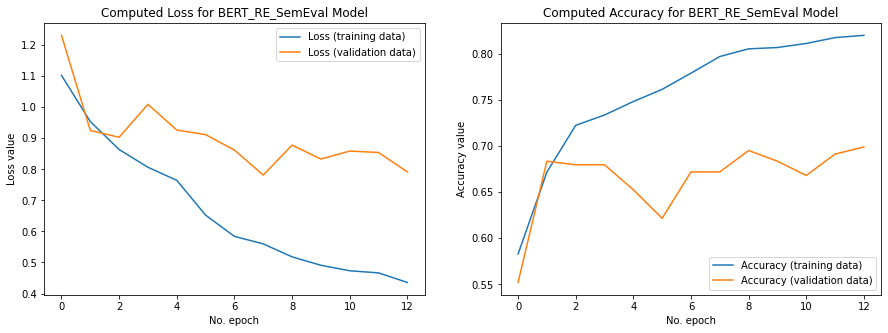

In [ ]:
# Define figure
fig_results = plt.figure(figsize=(15, 5))
ax_loss = fig_results.add_subplot(1, 2, 1)
ax_accuracy = fig_results.add_subplot(1, 2, 2)

# Plot history: Loss
ax_loss.plot(history.history['loss'], label='Loss (training data)')
ax_loss.plot(history.history['val_loss'], label='Loss (validation data)')
ax_loss.set_title('Computed Loss for BERT_RE_SemEval Model')
ax_loss.set_ylabel('Loss value')
ax_loss.set_xlabel('No. epoch')
ax_loss.legend(loc="upper right")

# Plot history: Accuracy
ax_accuracy.plot(history.history['accuracy'], label='Accuracy (training data)')
ax_accuracy.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
ax_accuracy.set_title('Computed Accuracy for BERT_RE_SemEval Model')
ax_accuracy.set_ylabel('Accuracy value')
ax_accuracy.set_xlabel('No. epoch')
ax_accuracy.legend(loc="lower right")
plt.show()

## 4. Evaluation and metrics

First, we compute the accuracy of the trained model in terms of validation and test.

In [ ]:
# Scores of the accuracy of trained network in validation
validation_scores = model.evaluate([val_inp, val_mask], val_label, verbose=2)
print("Validation loss:", validation_scores[0])
print("Validation accuracy:", validation_scores[1])

# Scores of the accuracy of trained network in test
test_scores = model.evaluate([test_inp, test_mask], test_label, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

9/9 - 3s - loss: 0.7815 - accuracy: 0.6718
Validation loss: 0.7815081477165222
Validation accuracy: 0.6718146800994873
21/21 - 7s - loss: 0.8781 - accuracy: 0.6682
Test loss: 0.8781102895736694
Test accuracy: 0.668188750743866


For the evaluation of the model, accuracy alone doesn’t truly reflect the performance of our model, so we use the predict function, which outputs the probability for each class. The index of the maximum corresponds to the actual prediction. Two implementations:
- Case 1: If the current trained model is the one to be evaluated.
- Case 2: If a previous trained model is to be loaded and evaluated.

In [ ]:
# Definition of the current model is to be evaluated
current_model_evaluated = True # Defined by user

if current_model_evaluated:
  # Predictions of the trained network in validation
  prediction_probabilities_validation = model.predict([val_inp, val_mask])
  predictions_validation = [np.argmax(pred) for pred in prediction_probabilities_validation.logits] # predictions represented as integer category
  y_true_validation = [value for value in val_label] # actual values represented as integer category
  
  # Predictions of the trained network in test
  prediction_probabilities_test = model.predict([test_inp, test_mask])
  predictions_test = [np.argmax(pred) for pred in prediction_probabilities_test.logits] # predictions represented as integer category
  y_true_test = [value for value in test_label] # actual values represented as integer category
  print('Current model evaluation finished')

else:
  trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_CLASSES)
  trained_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])
  trained_model.load_weights(CHECKPOINT_FILEPATH)

  # Predictions of the trained network in validation
  prediction_probabilities_validation = trained_model.predict([val_inp, val_mask])
  predictions_validation = [np.argmax(pred) for pred in prediction_probabilities_validation.logits] # predictions represented as integer category
  y_true_validation = [value for value in val_label] # actual values represented as integer category

  # Predictions of the trained network in test
  prediction_probabilities_test = trained_model.predict([input_ids_test, attention_masks_test])
  predictions_test = [np.argmax(pred) for pred in prediction_probabilities_test.logits] # predictions represented as integer category
  y_true_test = [value for value in labels_test] # actual values represented as integer category
  print('Loaded model evaluation finished')

Current model evaluation finished


The confusion matrix and the classification report are then displayed. They presents the precision, recall and f1 score for each class.

1.   Confusion Matrix representation

Each line corresponds to the true label and each column to the prediction. The scale bar is expressed as percentages.

Confusion matrix in validation:
[[126   5   9   3   0]
 [  2   4   3   2   0]
 [ 26   0  35   7   0]
 [ 12   0   4   9   0]
 [  6   0   4   2   0]]
Confusion matrix in test:
[[331  14  44  19   0]
 [ 15   7   7   0   0]
 [ 56   4  81  13   0]
 [ 27   0   5  19   0]
 [  5   1   6   2   1]]


Text(0.5, 1.0, 'Confusion Matrix for Test')

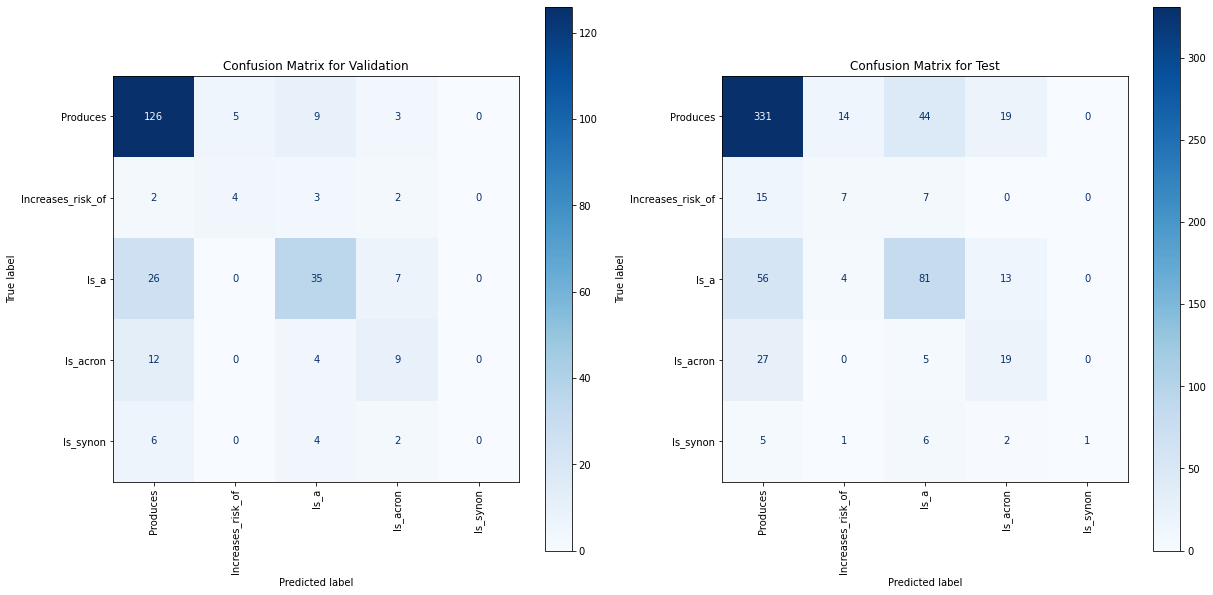

In [ ]:
relations = ['Produces',
            'Increases_risk_of',
            'Is_a',
            'Is_acron',
            'Is_synon',        
]

# Calculating Confusion Matrix in validation
cm_val = confusion_matrix(y_true_validation, predictions_validation)
print('Confusion matrix in validation:', cm_val, sep='\n')

# Calculating Confusion Matrix in test
cm_test = confusion_matrix(y_true_test, predictions_test)
print('Confusion matrix in test:', cm_test, sep='\n')

# Visualizing both Confusion Matrix
fig_cm = plt.figure(figsize=(20,10))
ax1_cm = fig_cm.add_subplot(1,2,1)
ax2_cm = fig_cm.add_subplot(1,2,2)
ConfusionMatrixDisplay(cm_val, display_labels=relations).plot(cmap='Blues', xticks_rotation='vertical', values_format='', ax=ax1_cm)
ConfusionMatrixDisplay(cm_test, display_labels=relations).plot(cmap='Blues', xticks_rotation='vertical', values_format='', ax=ax2_cm)
ax1_cm.set_title('Confusion Matrix for Validation')
ax2_cm.set_title('Confusion Matrix for Test')

2.   Classification report representation

Builds a text report showing the main classification metrics.



In [ ]:
print('Classification report in validation:', classification_report(y_true_validation, predictions_validation, digits=4), sep='\n')
print('Classification report in test:', classification_report(y_true_test, predictions_test, digits=4), sep='\n')

Classification report in validation:
              precision    recall  f1-score   support

           0     0.7326    0.8811    0.8000       143
           1     0.4444    0.3636    0.4000        11
           2     0.6364    0.5147    0.5691        68
           3     0.3913    0.3600    0.3750        25
           4     0.0000    0.0000    0.0000        12

    accuracy                         0.6718       259
   macro avg     0.4409    0.4239    0.4288       259
weighted avg     0.6282    0.6718    0.6443       259

Classification report in test:
              precision    recall  f1-score   support

           0     0.7627    0.8113    0.7862       408
           1     0.2692    0.2414    0.2545        29
           2     0.5664    0.5260    0.5455       154
           3     0.3585    0.3725    0.3654        51
           4     1.0000    0.0667    0.1250        15

    accuracy                         0.6682       657
   macro avg     0.5914    0.4036    0.4153       657
weighted 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
